## <center>QOSF Mentorship Program Cohort-9 Screening Task</center></nospace>
### <center>Submission by: Haemanth Velmurugan</center>

### Task 1: Less than k

Given a positive integer $“k”$ and a list of integer numbers, look for the numbers within the list, that are less than $k$. Consider an appropriate number of qubits and explain why your proposal is valid for all kinds of numbers in case 


def less_than_k (int: k, list[int]: list_n): <br>
     &emsp; ''' <br>
     &emsp; k : integer value that is the positive number to compare in list_n <br>
     &emsp; list_n : integer list that has positive numbers <br>
     &emsp; Return the numbers that are in list_n and are less than k <br>
     &emsp; ''' <br>

     # use a framework that works with quantum circuits, qiskit, cirq, pennylane, etc. 
     # consider print your quantum circuit,


**Example:**

A = less_than_k (7,[4,9,11,14,1,13,6,15]) <br>
print(A)

Output: “4,1,6”

**References:**

[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558. <br><br>
[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473. <br><br>
[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), arXiv:quant-ph/9605043


### Approach:

There are $3$ main questions to be addressed:
* How to encode the list of numbers $list\_n$ efficiently?
* How to compare the numbers from the list with the integer input $k$?
* How to select only those numbers which are less than the input $k$?

Figuring out the answers to these questions are enough to solve the task given. It is also important to bear in mind that the advantage of using quantum computing can only be seen when leveraging principles like superposition and entanglement without which one could just as well implement a classical algorithm to solve the task.

Let us examine how each of these can be addressed - both the idea and code using Qiskit

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.circuit.library import XGate, ZGate, MCMT, GroverOperator, CDKMRippleCarryAdder
from qiskit.algorithms import Grover
import numpy as np
from qiskit.visualization import plot_histogram

C:\Users\HAEMANTH\AppData\Local\Temp\ipykernel_7916\1431471356.py:3: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import Grover


***1. Encoding strategy - QRAM:***

Preparing an equal superposition of states is straightforward. However, in our case, we have a list of numbers and preparing a superposition of only the list elements is non-trivial and may even be costly. One other approach based on QRAMs encodes the elements in $|index\rangle|value\rangle$ format. The steps to achieve this are as follows:

* Create two registers - one to store the indices and the other to store the values of appropriate lengths
* Create an equal superposition of all qubits in the index register
* Entangle each index with the corresponding list value using CNOT gates
* Unused indices will correspond to $0$ value

Consider an index register $i$ of $2$ qubits and value register $v$ of $3$ qubits. In order to store the element $5$ at index $2$ we use the following circuit:
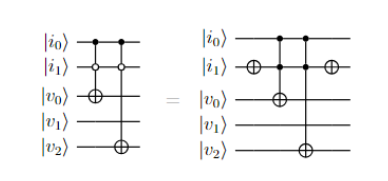

The index register has to act as control for the value $|i_0i_1\rangle = |10\rangle$. So the control gates are $1$-value controlled on $i_0$ and $0$-value controlled on $i_1$. </br>
The value to be stored is $|v_0v_1v_2\rangle = |101\rangle$. Hence we set only the $v_0$ and $v_2$ qubits for this index.

The integer input $k$ is encoded usinf Basis Encoding strategy. 

In [2]:
def get_size_bin(num):
    '''
    num - A positive integer 
    
    Returns the number of bits needed to represent the number num in binary
    '''
    return int(np.ceil(np.log2(num)))   

def encode_as_QRAM(num_list, index_len, data_len):
    '''
    num_list - List of numbers (array) to be encoded
    index_len - number of bits needed to represent indices
                Also the length of the index register that stores the indices of the elements in the array 
    data_len - number of bits needed to represent the values (data) in the array
               Also the length of the value (data) register that stores the elements in the array
    
    Returns a quantum circuit encoding the data num_list in the form |index>|value>
    '''
    # Define the quantum registers and the circuit
    index_reg = QuantumRegister(index_len)
    data_reg = QuantumRegister(data_len)
    qc = QuantumCircuit(index_reg, data_reg, name='QRAM')
    
    # start with an equal superposition of all indices
    qc.h(index_reg)
    
    mcnot = XGate().control(index_len)  
    # The multi-controlled NOT gate to entangle indices and their corresponding array data
    
    for idx, data in enumerate(num_list):
        
        bin_idx = format(idx, f'0{index_len}b')  # convert index (integer) to binary
        
        idx_0_bits = [i for i, digit in enumerate(reversed(bin_idx)) if digit == '0']  # find all the 0 bits in index (binary) 
        ### if index bit is 0, we apply an X gate followed by the traditional CNOT gate which is controlled by the value 1
        ### Applying X gates to these indices before CNOT, would result in a 0-value-controlled CNOT.
        
        control_0 = False  # flag indicating whether any X gates are needed before the CNOT
        
        # retrieve the index qubits (control qubits) which will be zero-valued controls in the multi-controlled-NOT gate
        if len(idx_0_bits) > 0:
            control_0_bits = index_reg[idx_0_bits]
            control_0 = True
        
        bin_data = format(data, f'0{data_len}b')        
        data_set_bits = [i for i, digit in enumerate(reversed(bin_data)) if digit == '1']
        # we need to set only these bits in the data register for the current index 
        
        if control_0:
            qc.x(control_0_bits)   # transform 0-valued controls into 1-valued controls by applying X gate
            
        for bit in data_set_bits:
            qc.append(mcnot, index_reg[:] + [data_reg[bit]])  
            # encode the data value by setting the required bits to 1 controlled by the current index value 
            # (establishing entanglement between the index and value)
        
        if control_0:
            qc.x(control_0_bits)   # undo the X gates applied to use 0-valued control qubits
            
    return qc

In [3]:
def execute_circ(qc):
    '''
    qc - quantum circuit to run on qasm simulator
    
    Returns the circuit measurement outcomes over 1024 shots
    '''
    job = execute(qc, Aer.get_backend('qasm_simulator'), shots=1024)
    counts = job.result().get_counts(qc)
    return counts

Test

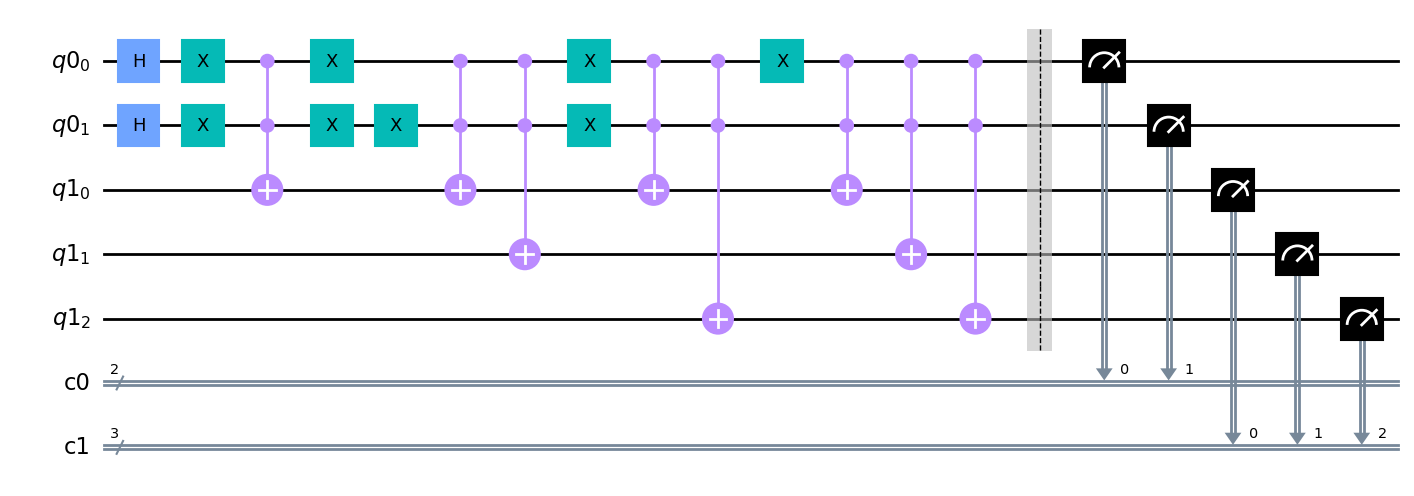

In [4]:
qc = encode_as_QRAM([1,3,5,7], index_len=2, data_len=3)

index_creg = ClassicalRegister(2)
data_creg = ClassicalRegister(3)
qc.barrier()
qc.add_register(index_creg, data_creg)
qc.measure(range(2), index_creg)
qc.measure(range(2,5), data_creg)
qc.draw('mpl')

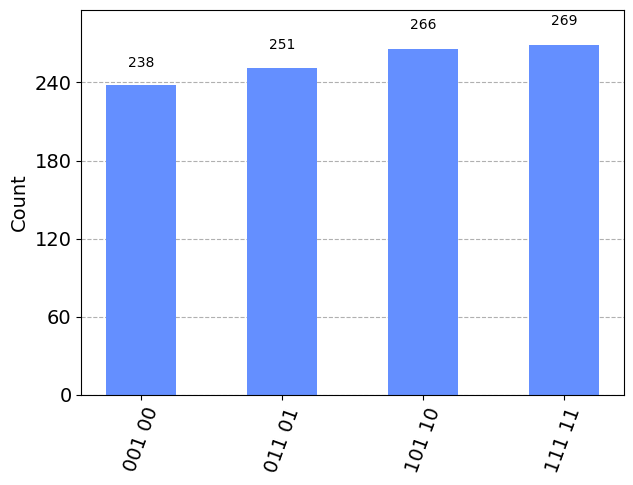

In [5]:
counts = execute_circ(qc)
plot_histogram(counts)

In [6]:
def encode_integer(k, data_len):
    '''
    k - integer value to be encoded
    data_len - length of the register to be used for encoding
    
    Returns the circuit that encodes the classical input k as a quantum state following Basis encoding
    '''
    data_reg = QuantumRegister(data_len)
    qc = QuantumCircuit(data_reg, name='Basis_Encoding')
    
    bin_data = format(k, f'0{data_len}b')        
    data_set_bits = [i for i, digit in enumerate(reversed(bin_data)) if digit == '1']
    
    qc.x(data_set_bits)
    
    return qc

Test

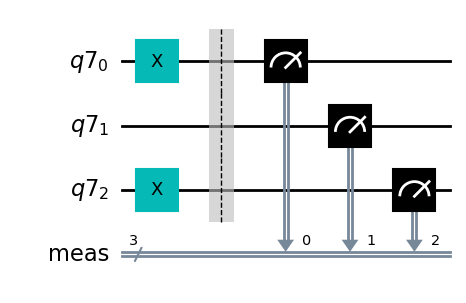

In [7]:
qc = encode_integer(5, 3)
qc.measure_all()
qc.draw('mpl')

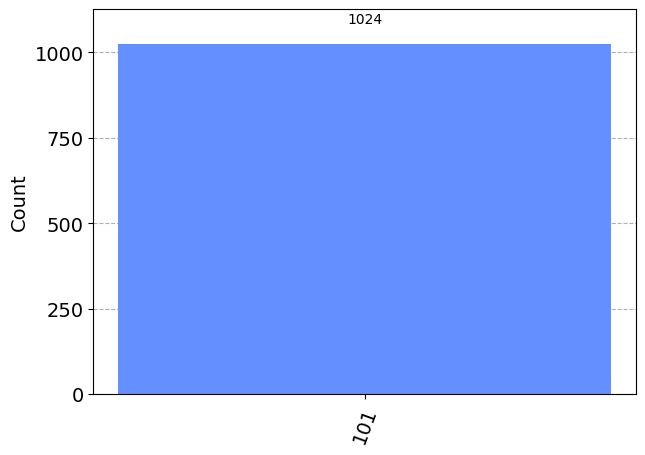

In [8]:
counts = execute_circ(qc)
plot_histogram(counts)

***2. Comparing the list elements with the input $k$:***

One approach to compare two $n$-bit numbers $a$ and $b$ (more specifically, to check if $a<b$) is to subtract $b$ from $a$ and check for overflows in the $n+1$-bit difference register. One can convert the existing adders to subtractors using the following modification as shown in [1]

<div>
<img src="Subtractor%20design.png" width="300"/>
</div>
 

There are 3 main approaches to quantum addition:
| Method          | Ancilla| Gates    | Depth       |
|  -----          | -----  | -----    | -----       |
| QFT             | $0$    | $O(n^2)$ | $O(n)$      |
| Ripple carry    | $1$    | $O(n)$   | $O(n)$      |
| Carry lookahead | $O(n)$ | $O(n)$   | $O(\log n)$ |

Based on the qubits, gates and depths suitable for the hardware being used, one can choose whichever approach is practical and affordable. There are pre-defined adders like DraperQFTAdder and VBERippleCarryAdder available in Qiskit as well.
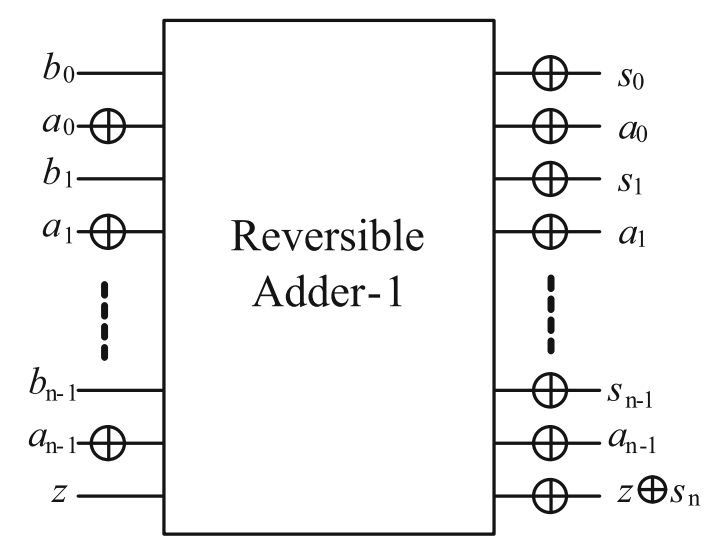

However, it is not necessary to perform the entire subtraction operation. We are interested only in the Most Significant Bit (MSB) of the difference and not the value itself. If MSB is $1$, then the difference register has overflowed indicating a negative result (which means the minuend ($a$) is smaller than the subtrahend ($b$) i.e $a<b$ in $a-b$). Therefore, it is not necessary to perform the entire subtraction operation. Such a comparison operation can easily be obtained by modifying the adder circuit shown as explained in [3]

<div>
<img src="quantum%20ripple%20adder.png" width="600"/>
</div>

In the above circuit, the first half of the circuit computes the high bit. The second half consisting of $UMA$ gates can simply be replaced by $MAJ^{-1}$ gates to convert this adder to a high-bit only circuit. By combining the adder-to-subtractor conversion along with this high-bit-only-computation circuit, one can implement the comparison operator such that the output qubit $z$ stores the result of the comparison $a<b$.

References:

[1] H. Thapliyal, "Mapping of subtractor and adder-subtractor circuits on reversible quantum gates," Transactions on Computational Science XXVII, pp. 10-34. Berlin, Heidelberg: Springer Berlin Heidelberg, 2016.

[2] T. G. Draper, “Addition on a quantum computer,” arXiv preprint quant-ph/0008033, 2000

[3] S. A. Cuccaro, T. G. Draper, S. A. Kutin, and D. P. Moulton, “A new quantum ripple-carry
addition circuit,” arXiv preprint quant-ph/0410184, 2004

[4] T. G. Draper, S. A. Kutin, E. M. Rains, and K. M. Svore, “A logarithmic-depth quantum
carry-lookahead adder,” Quantum Information & Computation, vol. 6, no. 4, p. 351–369,
2006

[5] https://qiskit.org/documentation/stubs/qiskit.circuit.library.DraperQFTAdder.html

[6] https://qiskit.org/documentation/stubs/qiskit.circuit.library.VBERippleCarryAdder.html
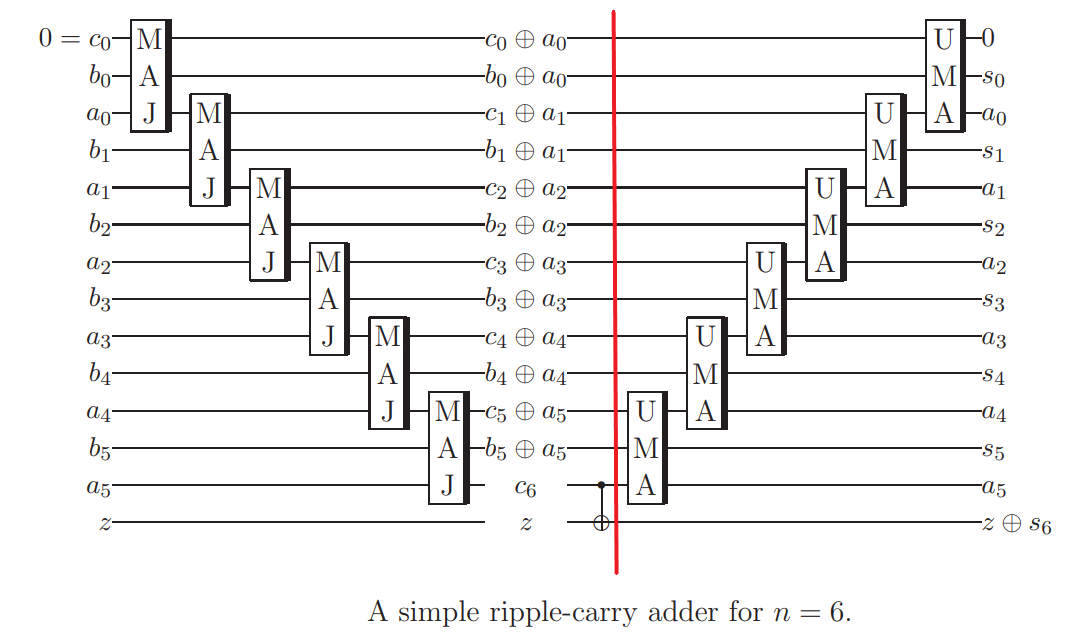

In [9]:
def maj_gate():
    '''
    Returns a quantum circuit that computes the majority of 3 bits in-place
    '''
    qreg = QuantumRegister(3)
    qc = QuantumCircuit(qreg, name='MAJ')
    
    qc.cnot(2,0)
    qc.cnot(2,1)
    qc.toffoli(0,1,2)
    
    return qc

In [10]:
def uma_gate():
    '''
    Returns a quantum circuit that performs UnMajority and Add (full adder) operations for 3 bits
    '''
    qreg = QuantumRegister(3)
    qc = QuantumCircuit(qreg, name='UMA')
    
    qc.x(1)
    qc.cnot(0,1)
    qc.toffoli(0,1,2)
    qc.x(1)
    qc.cnot(2,0)
    qc.cnot(2,1)
    
    return qc

In [11]:
def HighBitCalc(data_len):
    '''
    data_len - length of the binary representation of the inputs
    
    Returns a quantum circuit that computes only the high-bit or MSB of the sum a+b for two given inputs a and b
    '''
    
    a = QuantumRegister(data_len)   # data_reg
    b = QuantumRegister(data_len)   # k_reg
    high_bit = QuantumRegister(1)      
    c_in = QuantumRegister(1)
    
    qc = QuantumCircuit(c_in, a, b, high_bit, name='High Bit Calc')
    
    maj = maj_gate()
    
    ci = c_in[:]
    for i in range(data_len):
        qc.append(maj, ci[:] + b[i:i+1] + a[i:i+1])
        ci = [a[i]]
        
    qc.cnot(a[-1], high_bit)
    qc.barrier()
    
    maj_inv = maj.inverse()  # uma_gate()
    for i in range(data_len-1, 0, -1):
        ci = [a[i-1]]
        qc.append(maj_inv, ci[:] + b[i:i+1] + a[i:i+1])
        
    qc.append(maj_inv, c_in[:] + b[0:1] + a[0:1])
    
    return qc

Test

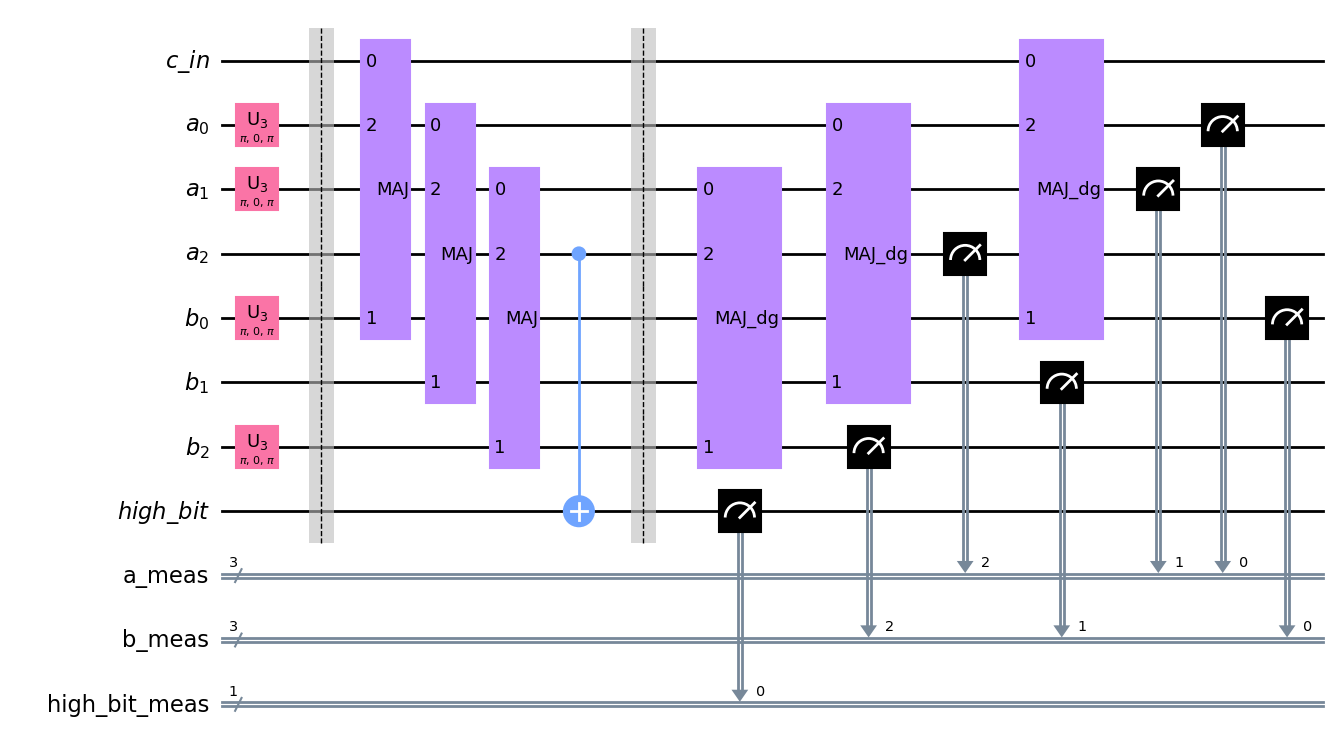

In [12]:
c_in = QuantumRegister(1, name="c_in")
a = QuantumRegister(3, name="a")
b = QuantumRegister(3, name='b')
high_bit = QuantumRegister(1, name='high_bit')
a_creg = ClassicalRegister(3, name="a_meas")
b_creg = ClassicalRegister(3, name="b_meas")
high_bit_creg = ClassicalRegister(1, name='high_bit_meas')
qc = QuantumCircuit(c_in, a, b, high_bit, a_creg, b_creg, high_bit_creg)

qc.x(b[0:3:2]) # b = 5
qc.x([a[0], a[1]]) # b=3
qc.barrier()
adder = HighBitCalc(3)
qc.append(adder, range(8))
qc.measure(a, a_creg)
qc.measure(b, b_creg)
qc.measure(high_bit, high_bit_creg)
qc.decompose().draw('mpl')

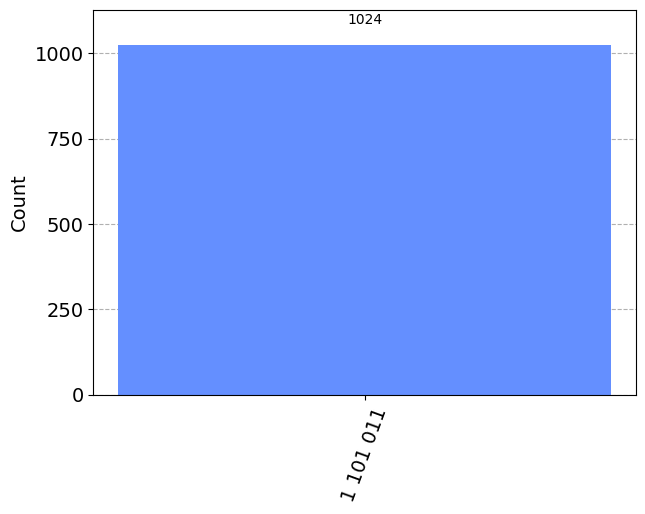

In [13]:
counts = execute_circ(qc)
plot_histogram(counts)

In [14]:
def comparator(data_len):
    '''
    data_len - length of the binary representation of the inputs
    
    Returns a quantum circuit that performs the comparison operation by modifying subtractor circuits to 
    compute only the high-bit (stores the result of a<b)
    '''
    
    a = QuantumRegister(data_len)
    b = QuantumRegister(data_len)
    high_bit = QuantumRegister(1)
    c_in = QuantumRegister(1)
    
    qc = QuantumCircuit(c_in, a, b, high_bit, name='Comparator')
    qc.x(a)
    adder = HighBitCalc(data_len)
    qc.append(adder, c_in[:] + a[:] + b[:] + high_bit[:])
    qc.x(a)
    # qc.x(b)
    # qc.x(c_out)
    
    return qc

Test

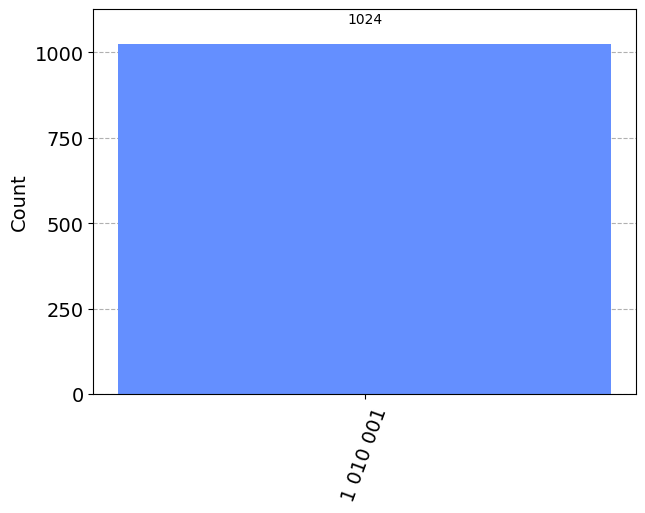

In [18]:
c_in = QuantumRegister(1, name="c_in")
a = QuantumRegister(3, name="a")
b = QuantumRegister(3, name='b')
high_bit = QuantumRegister(1, name='high_bit')
a_creg = ClassicalRegister(3, name="a_meas")
b_creg = ClassicalRegister(3, name="b_meas")
comp_creg = ClassicalRegister(1, name='a<b')
qc = QuantumCircuit(c_in, a, b, high_bit, a_creg, b_creg, comp_creg)

qc.x(a[0])  # a=1
qc.x(b[1])  # b=2

sub_circ = comparator(3)
qc.append(sub_circ, c_in[:] + a[:] + b[:] + high_bit[:])

qc.measure(a, a_creg)
qc.measure(b[:], b_creg)
qc.measure(high_bit, comp_creg)

counts = execute_circ(qc)
plot_histogram(counts)

In [19]:
def state_preparation_circuit(num_list, k, index_len, data_len):
    '''
    num_list: The list of numbers to be encoded
    k: The integer input to be encoded
    index_len: Length of the index register used to index the elements in num_list
    data_len: Length of the data register used to store the elements of num_list and k
    
    Returns a quantum circuit that encodes the list num_list and integer k as quantum data and 
    performs the comparison operation between the elements of num_list and k 
    (checks whether num_list_i < k for every element num_list_i in num_list)
    '''
    
    index_reg = QuantumRegister(index_len)
    data_reg = QuantumRegister(data_len)
    k_reg = QuantumRegister(data_len)
    c_out = QuantumRegister(1)
    ancilla = QuantumRegister(1)
    
    qc = QuantumCircuit(index_reg, data_reg, k_reg, c_out, ancilla)   
    
    # entangling index and value
    encode_circ = encode_as_QRAM(num_list, index_len, data_len)
    qc.append(encode_circ, index_reg[:] + data_reg[:])
    
    encode_k_circ = encode_integer(k, data_len)
    qc.append(encode_k_circ, k_reg[:])
    
    # Subtraction
    sub_circ = comparator(data_len)
    qc.append(sub_circ, ancilla[:] + data_reg[:] + k_reg[:] + c_out[:])
    
    # adder_circ = adder(data_len)
    # qc.append(adder_circ, data_reg_1[:] + data_reg_2[:-1] + carry[:] + data_reg_2[-1:] + ancilla[:])
            
    return qc

Test

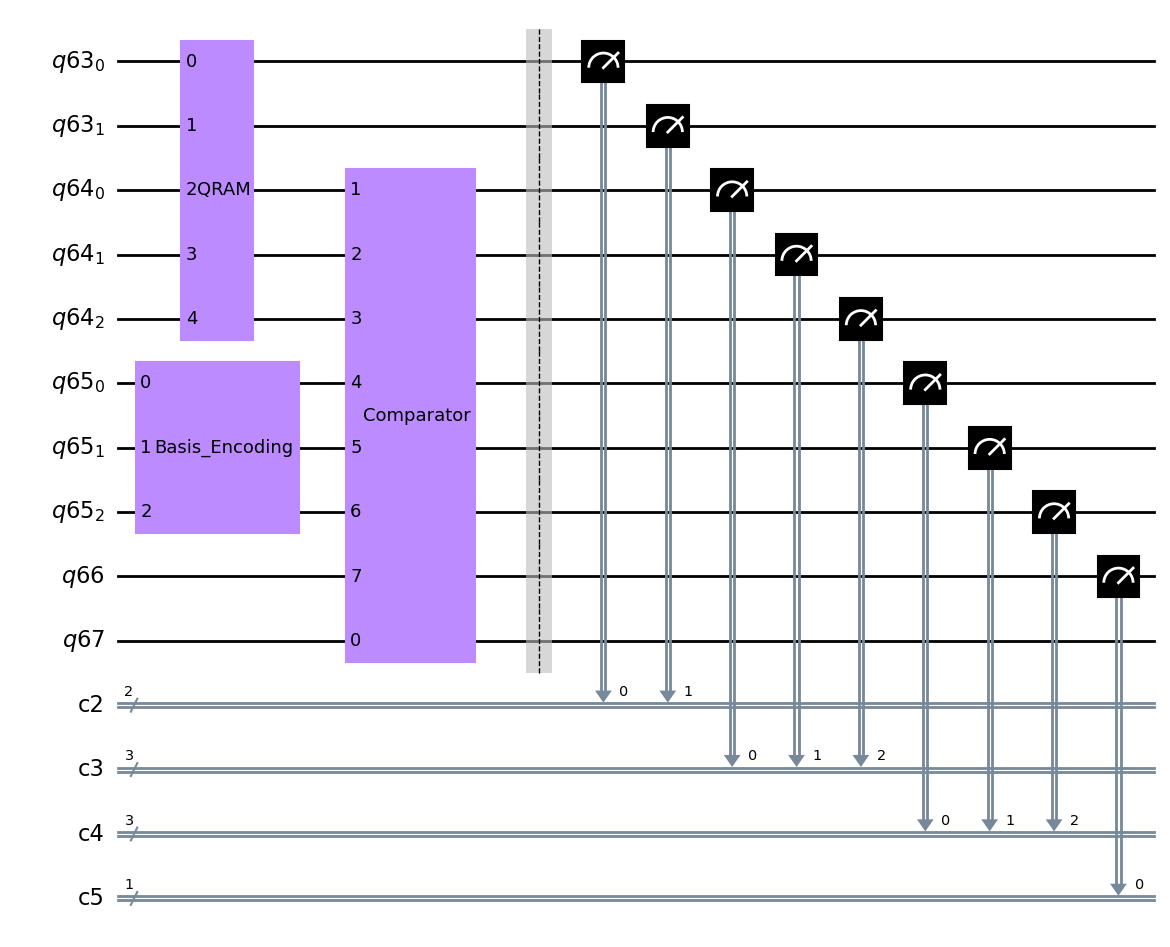

In [20]:
qc = state_preparation_circuit(num_list=[1,3,5,7], k=5, index_len=2, data_len=3)

index_creg = ClassicalRegister(2)
data_creg = ClassicalRegister(3)
diff_creg = ClassicalRegister(3)
ancilla = ClassicalRegister(1)
qc.barrier()
qc.add_register(index_creg, data_creg, diff_creg, ancilla)
qc.measure(range(2), index_creg)
qc.measure(range(2,5), data_creg)
qc.measure(range(5,8), diff_creg)
qc.measure(8, ancilla)
qc.draw('mpl')

In [21]:
counts = execute_circ(qc)

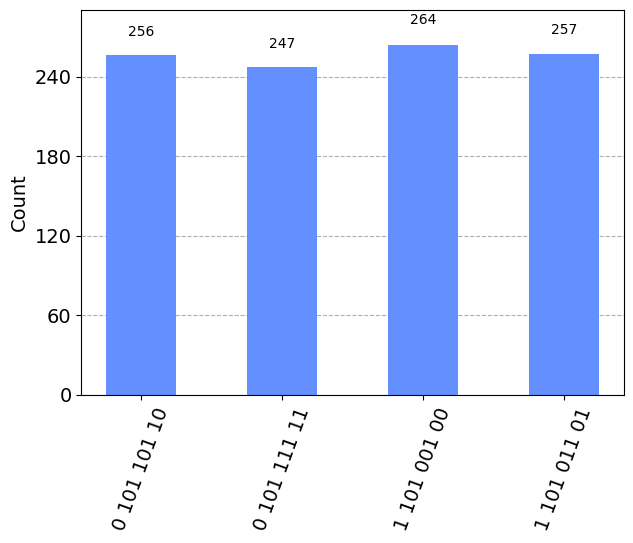

In [22]:
plot_histogram(counts)

***3. Selecting only those numbers which are less than the input $k$:***

Our circuit encodes the result of the comparison $list\_n_{i} < k$ in the ancillary bit. The next step is to find a way to retain only those states which are less than $k$ (can be determined based on the value of the ancillary bit).

One approach to achieving this is using Amplitude Amplification. By using an oracle that marks states which are less than $k$, we could increase the amplitude of those states alone and decrease the amplitude of the rest as much as possible by selecting an appropriate number of iterations.

The general structure of the iterative block in amplitude amplification is of the form: 
$U = ADA^{\dagger}O$
where $A$ is the state preparation operator (includes the QRAM encoding as well as the comparison operations), $D$ is the diffuser and $O$ is the oracle. The oracle simply inverts the amplitude of the states that are part of our solution by flipping their sign. The diffuser amplifies the corresponding amplitudes of the solution states by reflecting it around the mean and also decreases the amplitudes of the non-solution states.

The procedure described above is a generalization of the famous Grover's search algorithm which requires the initial state to be an equal superposition of all possible basis states.

In Qiskit, we have the GroverOperator primitive, that takes as input the oracle function and applies the diffusion operator implicitly. The oracle here is the basic phase oracle, that will flip the amplitudes of states which are less than $k$. This can be achieved by applying an $Z$ gate to the ancillary bit that will flip the sign of a state whenever it is less than $k$.

References:

[1] Brassard, Gilles, Peter Hoyer, Michele Mosca, and Alain Tapp. "Quantum amplitude amplification and estimation." Contemporary Mathematics 305 (2002): 53-74

[2] https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm

[3] https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm

In [23]:
def grover_oracle(total_len, target):
    '''
    total_len: Total number of qubits in the quantum circuit
    target: Qubit index on which the Phase flip oracle (simple Z gate) is to be applied
    
    Returns a quantum circuit implementing the phase flip oracle on the target qubit
    '''
    data_reg = QuantumRegister(total_len)
    qc = QuantumCircuit(data_reg, name='Oracle')
    
    qc.z(data_reg[target])
    
    return qc

#### Putting everything together

In [40]:
def create_circuit(k, list_n):
    """
    k : integer value that is the positive number to compare to list_n,
    list_n : integer list that has positive numbers.
    
    Returns a quantum circuit that selects (maximizes probability of observing) elements from list_n that are less than k
    """
    size = len(list_n)
    max_val = np.max(list_n)
    
    index_len = get_size_bin(size)
    data_len = max(get_size_bin(max_val), get_size_bin(k))
    
    # define all registers
    index_reg = QuantumRegister(index_len, name='index')
    data_reg = QuantumRegister(data_len, name='data')
    k_reg = QuantumRegister(data_len, name='k')
    c_out = QuantumRegister(1, name='c_out')
    ancilla = QuantumRegister(1, name='ancilla')
    
    index_creg = ClassicalRegister(index_len, name='index_meas')
    data_creg = ClassicalRegister(data_len, name='data_meas')
    c_out_creg = ClassicalRegister(1, name='c_out_meas')
    
    # Create the quantum circuit
    qc = QuantumCircuit(index_reg, data_reg, k_reg, c_out, ancilla, 
                        index_creg, data_creg, c_out_creg)
    
    state_prep_circ = state_preparation_circuit(list_n, k, index_len, data_len)
    qc.compose(state_prep_circ, inplace=True)
    
    # Grover's search
    oracle = grover_oracle(index_len + data_len*2 + 2, index_len + data_len*2)
    grover_op = GroverOperator(oracle, state_prep_circ) 
                              # reflection_qubits=list(range(index_len*2 + data_len, index_len*2 + data_len*2 + 1)))
    
    # display(oracle.draw('mpl'))

    # Determine the optimal iterations = 𝜋/4*√(N/k)
    num_sols = len([list_n_i for list_n_i in list_n if list_n_i < k])
    optimal_num_iterations = int(np.floor(np.pi/4 * np.sqrt(len(list_n)/num_sols)))

    qc.append(grover_op.power(optimal_num_iterations), index_reg[:] + data_reg[:] + k_reg[:] + c_out[:] + ancilla[:])
    
    qc.measure(index_reg, index_creg)
    qc.measure(data_reg, data_creg)
    qc.measure(c_out, c_out_creg)
    
    return qc

In [25]:
k = 7
list_n = [4,9,11,14,1,13,6,15]

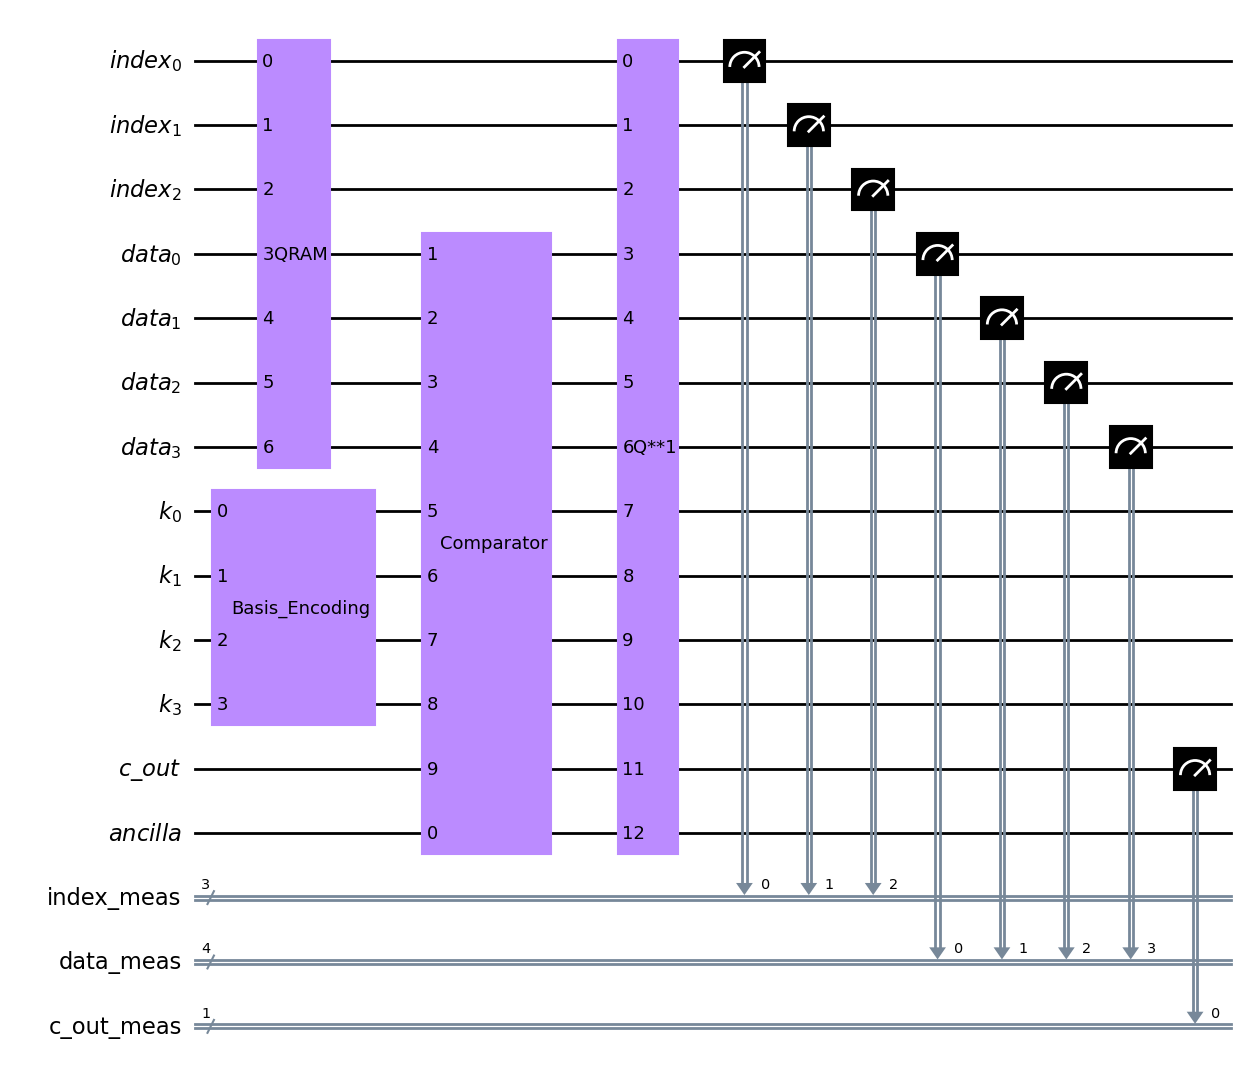

In [26]:
qc = create_circuit(k, list_n)
qc.draw('mpl')

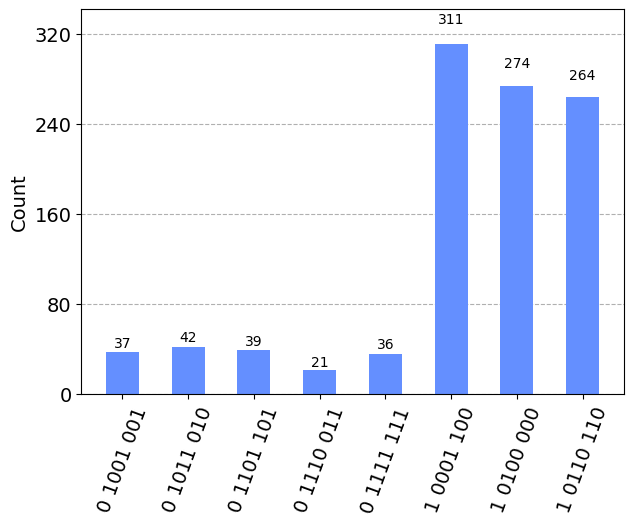

In [27]:
counts = execute_circ(qc)
plot_histogram(counts)

Upon performing amplitude amplification, it can be seen that there is a significant difference in the probabilities of observing those list elements which are less than the integer $k$ (since ancillary bit is $1$), than the others. This indicates that our circuit works as intended. A final step is to perform classical post-processing to filter out these smaller amplitudes and fetch the solution values from the bitstrings. Since list sizes may not always be a power of 2, we also consider 0s padded to the list which have to be removed during post-processing.

In [28]:
def bitstring_to_int(x):
    '''
    x: bitstring output of the quantum circuit we implemented
    
    Returns the integer output of the list element's bitstring encoding contained in x
    '''
    num = x.split(' ')[1]
    return int(num, 2)

In [29]:
def postprocessing_output(counts, list_size):
    '''
    counts: Dictionary storing the quantum circuit execution results of the form (basis state, probability)
    list_size: size/number of elements in the input list_n
    
    Returns the list elements with large probabilities of measuring
    '''
    threshold = 1024/2**(get_size_bin(list_size))   # 50% probability
    soln_bitstrings = {k:v for (k,v) in counts.items() if v >= threshold}
    
    solutions = []
    for x in soln_bitstrings:
        val = bitstring_to_int(x) 
        if val > 0:  # since list size may not be a power of 2, we omit zeros
            solutions.append(val)
    
    return solutions

In [30]:
solutions = postprocessing_output(counts, len(list_n))

In [31]:
print("The values from ", list_n, " that are less than ", k, " are ", solutions)

The values from  [4, 9, 11, 14, 1, 13, 6, 15]  that are less than  7  are  [1, 4, 6]


Test 2

In [32]:
import random

In [59]:
k = 10
list_n = list(range(1,20))
random.shuffle(list_n)
list_n = list_n[:8]
qc = create_circuit(k, list_n)
counts = execute_circ(qc)
solutions = postprocessing_output(counts, len(list_n))
print("The values from ", list_n, " that are less than ", k, " are ", solutions)

The values from  [17, 5, 10, 9, 11, 13, 14, 4]  that are less than  10  are  [9, 5, 4]


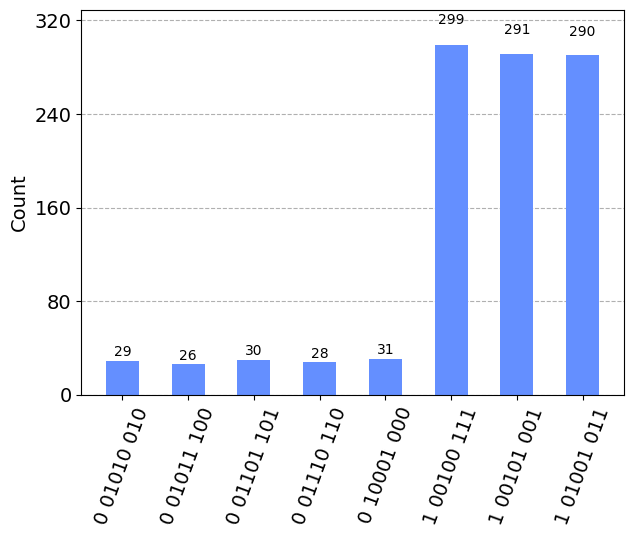

In [60]:
plot_histogram(counts)